In [1]:
# ----------------------
# Load required packages
# ----------------------

import gc
import sys, getopt
import ujson as json
import random
import datetime
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from covid19model.models import models
from covid19model.data import mobility, sciensano, model_parameters
from covid19model.models.time_dependant_parameter_fncs import ramp_fun
from covid19model.visualization.output import _apply_tick_locator 
# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [2]:
# -----------------------
# Load samples dictionary
# -----------------------

filename = 'BE_WAVE2_R0_COMP_EFF_2021-05-10.json'
# Path where MCMC samples are saved
samples_path = '../../data/interim/model_parameters/COVID19_SEIRD/calibrations/national/'

from covid19model.models.utils import load_samples_dict
samples_dict = load_samples_dict(samples_path+str(filename), wave=2)
warmup = int(samples_dict['warmup'])
start_calibration = samples_dict['start_calibration']
end_calibration = samples_dict['end_calibration']

In [3]:
# Time-integrated contact matrices
initN, Nc_all = model_parameters.get_integrated_willem2012_interaction_matrices()
levels = initN.size
# Sciensano data
df_sciensano = sciensano.get_sciensano_COVID19_data(update=False)
# Google Mobility data
df_google = mobility.get_google_mobility_data(update=False, plot=False)

In [4]:
from covid19model.models.time_dependant_parameter_fncs import  make_vaccination_function
sciensano_first_dose, df_sciensano_start, df_sciensano_end = make_vaccination_function(df_sciensano)

def vacc_strategy(t, states, param, df_sciensano_start, df_sciensano_end,
                    daily_dose=50000, delay = 21, vacc_order = [8,7,6,5,4,3,2,1,0], refusal = [0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3]):
    """
    time-dependent function for the Belgian vaccination strategy
    First, all available data from Sciensano are used. Then, the user can specify a custom vaccination strategy of "daily_dose" doses per day,
    given in the order specified by the vector "vacc_order" with a refusal propensity of "refusal" in every age group.
  
    Parameters
    ----------
    t : int
        Simulation time
    states: dict
        Dictionary containing values of model states
    param : dict
        Model parameter dictionary
    sciensano_first_dose : function
        Function returning the number of (first dose) vaccinated individuals at simulation time t, according to the data made public by Sciensano.
    df_sciensano_start : date
        Start date of Sciensano vaccination data frame
    df_sciensano_end : date
        End date of Sciensano vaccination data frame
    daily_dose : int
        Number of doses administered per day. Default is 30000 doses/day.
    delay : int
        Time delay between first dose vaccination and start of immunity. Default is 21 days.
    vacc_order : array
        Vector containing vaccination prioritization preference. Default is old to young. Must be equal in length to the number of age bins in the model.
    refusal: array
        Vector containing the fraction of individuals refusing a vaccine per age group. Default is 30% in every age group. Must be equal in length to the number of age bins in the model.

    Return
    ------
    N_vacc : array
        Number of individuals to be vaccinated at simulation time "t"
        
    """

    # Convert time to suitable format
    t = pd.Timestamp(t.date())
    # Convert delay to a timedelta
    delay = pd.Timedelta(str(int(delay))+'D')
    # Compute the number of vaccine eligible individuals
    VE = states['S'] + states['R']
    
    if t <= df_sciensano_start + delay:
        return np.zeros(9)
    elif df_sciensano_start + delay < t <= df_sciensano_end + delay:
        return sciensano_first_dose(t-delay)
    else:
        N_vacc = np.zeros(9)
        # Vaccines distributed according to vector 'order'
        # With residue 'refusal' remaining in each age group
        idx = 0
        while daily_dose > 0:
            if VE[vacc_order[idx]]*(1-refusal[vacc_order[idx]]) > daily_dose:
                N_vacc[vacc_order[idx]] = daily_dose
                daily_dose = 0
            else:
                N_vacc[vacc_order[idx]] = VE[vacc_order[idx]]*(1-refusal[vacc_order[idx]])
                daily_dose = daily_dose - VE[vacc_order[idx]]*(1-refusal[vacc_order[idx]])
                idx = idx + 1
        return N_vacc

# --------------------------------------
# Time-dependant social contact function
# --------------------------------------

# Extract build contact matrix function
from covid19model.models.time_dependant_parameter_fncs import make_contact_matrix_function, delayed_ramp_fun, ramp_fun
contact_matrix_4prev, all_contact, all_contact_no_schools = make_contact_matrix_function(df_google, Nc_all)

# Define policy function
def policies_full_relaxation(t, states, param, l , l_relax, prev_schools, prev_work, prev_rest, prev_home, relaxdate):
    
    t = pd.Timestamp(t.date())

    # Convert compliance tau and l to dates
    l_days = pd.Timedelta(l, unit='D')

    # Convert relaxation l to dates
    l_relax_days = pd.Timedelta(l_relax, unit='D')

    # Define key dates of first wave
    t1 = pd.Timestamp('2020-03-15') # start of lockdown
    t2 = pd.Timestamp('2020-05-15') # gradual re-opening of schools (assume 50% of nominal scenario)
    t3 = pd.Timestamp('2020-07-01') # start of summer holidays
    t4 = pd.Timestamp('2020-09-01') # end of summer holidays

    # Define key dates of second wave
    t5 = pd.Timestamp('2020-10-19') # lockdown (1)
    t6 = pd.Timestamp('2020-11-02') # lockdown (2)
    t7 = pd.Timestamp('2020-11-16') # schools re-open
    t8 = pd.Timestamp('2020-12-18') # Christmas holiday starts
    t9 = pd.Timestamp('2021-01-04') # Christmas holiday ends
    t10 = pd.Timestamp('2021-02-15') # Spring break starts
    t11 = pd.Timestamp('2021-02-21') # Spring break ends
    t12 = pd.Timestamp('2021-02-28') # Contact increase in children
    t13 = pd.Timestamp('2021-03-26') # Start of Easter holiday
    t14 = pd.Timestamp('2021-04-18') # End of Easter holiday
    t15 = pd.Timestamp(relaxdate) # Relaxation date
    t16 = pd.Timestamp('2021-07-01') # Start of Summer holiday
    t17 = pd.Timestamp('2021-09-01') 

    if t <= t1:
        return all_contact(t)
    elif t1 < t < t1:
        return all_contact(t)
    elif t1  < t <= t1 + l_days:
        policy_old = all_contact(t)
        policy_new = contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                                    school=0)
        return ramp_fun(policy_old, policy_new, t, t1, l)
    elif t1 + l_days < t <= t2:
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                              school=0)
    elif t2 < t <= t3:
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                              school=0)
    elif t3 < t <= t4:
        return contact_matrix_4prev(t, school=0)

    # Second wave
    elif t4 < t <= t5:
        return contact_matrix_4prev(t, school=1)
    elif t5  < t <= t5 + l_days:
        policy_old = contact_matrix_4prev(t, school=1)
        policy_new = contact_matrix_4prev(t, prev_schools, prev_work, prev_rest, 
                                    school=1)
        return ramp_fun(policy_old, policy_new, t, t5, l)
    elif t5 + l_days < t <= t6:
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                              school=1)
    elif t6 < t <= t7:
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                              school=0)
    elif t7 < t <= t8:
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                              school=1) 
    elif t8 < t <= t9:
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                              school=0)
    elif t9 < t <= t10:
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                              school=1)
    elif t10 < t <= t11:
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                              school=0)    
    elif t11 < t <= t12:
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                              school=1)
    elif t12 < t <= t13:
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest,
                            school=1)
    elif t13 < t <= t14:
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                                school=0)                           
    elif t14 < t <= t15:
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                            school=1)   
    elif t15 < t <= t15 + l_relax_days:
        policy_old = contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                            school=1)
        policy_new = contact_matrix_4prev(t, prev_schools, prev_work, prev_rest, 
                            work=1, leisure=1, transport=1, others=1, school=1)
        return ramp_fun(policy_old, policy_new, t, t15, l_relax)
    elif t15 + l_relax_days < t <= t16:
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                            work=1, leisure=1, transport=1, others=1, school=1)
    elif t16 < t <= t17:
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                            work=0.8, leisure=1, transport=0.90, others=1, school=0)                                      
    else:
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                            work=1, leisure=1, transport=1, others=1, school=1)

In [5]:
# ---------------------------
# Time-dependant VOC function
# ---------------------------

from covid19model.models.time_dependant_parameter_fncs import make_VOC_function
VOC_function = make_VOC_function()

def stratified_VOC_func(t,states,param):
    t = pd.Timestamp(t.date())
    t_sig = pd.Timestamp('2021-07-01')
    t1 = pd.Timestamp('2021-05-15')
    
    if t <= t1:
        return np.array([1-VOC_function(t), VOC_function(t), 0])
    else:
        k=0.3
        frac = 1/(1+np.exp(-k*(t-t_sig)/pd.Timedelta(days=1)))
        return np.array([0, 1-frac, frac])

In [6]:
def draw_fcn_WAVE2(param_dict,samples_dict):
    """
    A function to draw samples from the posterior distributions of the model parameters calibrated to WAVE 2
    Tailored for use with the national COVID-19 SEIQRD

    Parameters
    ----------

    samples_dict : dict
        Dictionary containing the samples of the national COVID-19 SEIQRD model obtained through calibration of WAVE 2

    param_dict : dict
        Model parameters dictionary

    Returns
    -------
    param_dict : dict
        Modified model parameters dictionary

    """

    # Calibration of WAVE 1
    # ---------------------
    idx, param_dict['zeta'] = random.choice(list(enumerate(samples_dict['zeta'])))

    # Calibration of WAVE 2
    # ---------------------
    idx, param_dict['beta'] = random.choice(list(enumerate(samples_dict['beta'])))
    param_dict['da'] = samples_dict['da'][idx]
    param_dict['l'] = samples_dict['l'][idx]  
    param_dict['prev_schools'] = samples_dict['prev_schools'][idx]    
    param_dict['prev_home'] = samples_dict['prev_home'][idx]      
    param_dict['prev_work'] = samples_dict['prev_work'][idx]       
    param_dict['prev_rest'] = samples_dict['prev_rest'][idx]
    param_dict['K_inf'] = np.array([1, samples_dict['K_inf'][idx], samples_dict['K_inf'][idx]*np.random.uniform(low=1.3,high=1.5)])
    param_dict['K_hosp'] = np.array([1, np.random.uniform(low=1.3,high=1.5), np.random.uniform(low=1.3,high=1.5)])

    # Vaccination
    # -----------
    param_dict['daily_dose'] = np.random.uniform(low=60000,high=80000)
    param_dict['delay'] = np.mean(np.random.triangular(1, 30, 30, size=30))
    param_dict['e_i'] = np.array([np.random.uniform(low=0.8,high=1),
                                  np.random.uniform(low=0.8,high=1),
                                  np.random.uniform(low=0.8,high=1)])
    param_dict['e_s'] = np.array([np.random.uniform(low=0.90,high=0.99),
                                  np.random.uniform(low=0.90,high=0.99),
                                  np.random.uniform(low=0.50,high=0.75)])                          
    param_dict['e_h'] = np.array([np.random.uniform(low=0.8,high=1.0),
                                  np.random.uniform(low=0.8,high=1.0),
                                  np.random.uniform(low=0.8,high=1.0)])
    param_dict['refusal'] = [np.random.triangular(0.05, 0.10, 0.20), np.random.triangular(0.05, 0.10, 0.20), np.random.triangular(0.05, 0.10, 0.20), # 60+
                             np.random.triangular(0.10, 0.20, 0.30),np.random.triangular(0.10, 0.20, 0.30),np.random.triangular(0.10, 0.20, 0.30), # 30-60
                             np.random.triangular(0.15, 0.20, 0.40),np.random.triangular(0.15, 0.20, 0.40),np.random.triangular(0.15, 0.20, 0.40)] # 30-

    # Hospitalization
    # ---------------
    # Fractions
    names = ['c','m_C','m_ICU']
    for idx,name in enumerate(names):
        par=[]
        for jdx in range(9):
            par.append(np.random.choice(samples_dict['samples_fractions'][idx,jdx,:]))
        param_dict[name] = np.array(par)
    # Residence times
    n=100
    distributions = [samples_dict['residence_times']['dC_R'],
                     samples_dict['residence_times']['dC_D'],
                     samples_dict['residence_times']['dICU_R'],
                     samples_dict['residence_times']['dICU_D']]
    names = ['dc_R', 'dc_D', 'dICU_R', 'dICU_D']
    for idx,dist in enumerate(distributions):
        param_val=[]
        for age_group in dist.index.get_level_values(0).unique().values[0:-1]:
            draw = np.random.gamma(dist['shape'].loc[age_group],scale=dist['scale'].loc[age_group],size=n)
            param_val.append(np.mean(draw))
        param_dict[names[idx]] = np.array(param_val)

    return param_dict

In [7]:
# -----------------------------
# Function to add poisson draws
# -----------------------------

from covid19model.models.utils import output_to_visuals

In [8]:
# -------------------------------------
# Initialize the model with vaccination
# -------------------------------------

# Model initial condition on September 1st
with open('../../data/interim/model_parameters/COVID19_SEIRD/calibrations/national/initial_states_2020-09-01.json', 'r') as fp:
    initial_states = json.load(fp)  

In [9]:
# Load the model parameters dictionary
params = model_parameters.get_COVID19_SEIRD_parameters(vaccination=True)
# Make vaccination parameters stratified
params.update({'alpha': np.array([1,0,0]),
              'K_inf': np.array([1,1.45,1.45*1.5]),
              'K_hosp': np.array([1,1.4,1.4]),
              'e_i': np.array([0.90,0.90,0.90]),
              'e_s': np.array([0.95,0.95,0.95]), # Indian variant lowers susceptibility to 60%
              'e_h': np.array([0.90,0.90,0.90]),
              'e_a': np.array([1.00,1.00,1.00])})
# Add the time-dependant parameter function arguments
# Social policies
params.update({'l': 21, 'prev_schools': 0, 'prev_work': 0.5, 'prev_rest': 0.5, 'prev_home': 0.5, 'relaxdate': '2021-06-01', 'l_relax': 31})
# Vaccination
params.update(
    {'vacc_order': np.array(range(9))[::-1], 'daily_dose': 55000,
     'refusal': 0.2*np.ones(9), 'delay': 21, 'df_sciensano_start': df_sciensano_start,
     'df_sciensano_end': df_sciensano_end}
)
# Initialize model
model = models.COVID19_SEIRD_vacc(initial_states, params,
                        time_dependent_parameters={'Nc': policies_full_relaxation, 'N_vacc': vacc_strategy, 'alpha': stratified_VOC_func})

In [10]:
# -------------------
# Perform simulations
# -------------------

n_samples = 50
n_draws_per_sample = 1
conf_int = 0.05
end_sim = '2021-09-01'

print('\n1) Simulating COVID-19 SEIRD '+str(n_samples)+' times')
start_sim = start_calibration
out = model.sim(end_sim,start_date=start_sim,warmup=warmup,N=n_samples,draw_fcn=draw_fcn_WAVE2,samples=samples_dict)
simtime, df_2plot = output_to_visuals(out, ['H_in', 'H_tot', 'ICU', 'D', 'R'], n_samples, n_draws_per_sample, LL = conf_int/2, UL = 1 - conf_int/2)


1) Simulating COVID-19 SEIRD 50 times


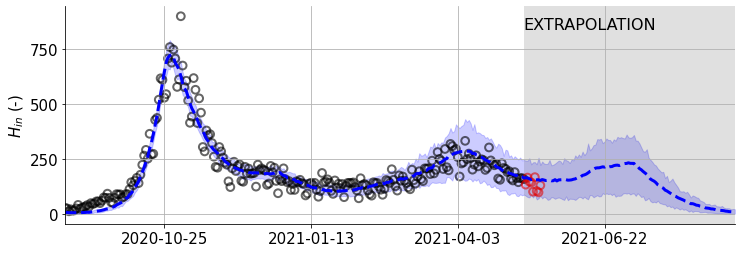

In [11]:
# -----------
# Visualizing
# -----------

fig,ax = plt.subplots(figsize=(12,4))
# Incidence
ax.plot(df_2plot['H_in','mean'],'--', color='blue')
ax.fill_between(simtime, df_2plot['H_in','LL'], df_2plot['H_in','UL'],alpha=0.20, color = 'blue')
ax.scatter(df_sciensano[start_calibration:end_calibration].index,df_sciensano['H_in'][start_calibration:end_calibration], color='black', alpha=0.6, linestyle='None', facecolors='none', s=60, linewidth=2)
ax.scatter(df_sciensano[pd.to_datetime(end_calibration)+datetime.timedelta(days=1):].index,df_sciensano['H_in'][pd.to_datetime(end_calibration)+datetime.timedelta(days=1):], color='red', alpha=0.6, linestyle='None', facecolors='none', s=60, linewidth=2)
ax.axvspan(end_calibration, '2021-12-31', facecolor='0.2', alpha=0.15)
ax.text(x=end_calibration,y=840,s='EXTRAPOLATION', fontsize=16)
ax = _apply_tick_locator(ax)
ax.set_xlim('2020-09-01',end_sim)
ax.set_ylabel('$H_{in}$ (-)')
fig.savefig('INDIAN_1.png', dpi=300, bbox_inches='tight')

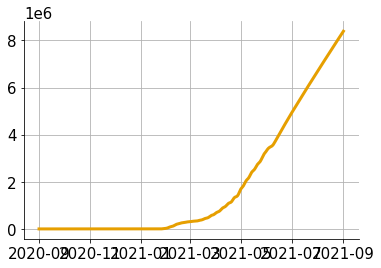

In [16]:
plt.plot(simtime,out['S_v'].sum(dim='Nc').mean(dim='draws'))